In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
from pathlib import Path		

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [2]:
import matplotlib.pyplot as plt

In [3]:
# ref: https://gis.stackexchange.com/questions/225065/converting-nztm-new-zealand-transverse-mercator-to-lat-long
import math
def nztm_to_lat_long(nztm_e, nztm_n):
    """ converting nztm to latitude and longitude
        #input Northing(Y); Easting(X) variables
    """
    #Common variables for NZTM2000
    a = 6378137;
    f = 1 / 298.257222101;
    phizero = 0;
    lambdazero = 173;
    Nzero = 10000000;
    Ezero = 1600000;
    kzero = 0.9996;   

    #input Northing(Y); Easting(X) variables
    N  = int(nztm_n);
    E  = int(nztm_e);

    #Calculation: From NZTM to lat/Long
    b = a * (1 - f);
    esq = 2 * f - f ** 2;
    Z0 = 1 - esq / 4 - 3 * (esq ** 2) / 64 - 5 * (esq ** 3) / 256;
    A2 = 0.375 * (esq + esq ** 2 / 4 + 15 * (esq ** 3) / 128);
    A4 = 15 * ((esq ** 2) + 3 * (esq ** 3) / 4) / 256;
    A6 = 35 * (esq ** 3) / 3072;

    Nprime = N - Nzero;
    mprime = Nprime / kzero;
    smn = (a - b) / (a + b);
    G = a * (1 - smn) * (1 - (smn ** 2)) * (1 + 9 * (smn ** 2) / 4 + 225 * (smn ** 4) / 64) * math.pi/ 180.0;
    sigma = mprime * math.pi / (180 * G);
    phiprime = sigma + (3 * smn / 2 - 27 * (smn ** 3) / 32) * math.sin(2 * sigma) + (21 * (smn ** 2) / 16 - 55 * (smn ** 4) / 32) * math.sin(4 * sigma) + (151 * (smn ** 3) / 96) * math.sin(6 * sigma) + (1097 * (smn ** 4) / 512) *math.sin(8 * sigma);
    rhoprime = a * (1 - esq) / ((1 - esq * ((math.sin(phiprime)) ** 2)) ** 1.5);
    upsilonprime = a / math.sqrt(1 - esq * ((math.sin(phiprime)) ** 2));

    psiprime = upsilonprime / rhoprime;
    tprime = math.tan(phiprime);
    Eprime = E - Ezero;
    chi = Eprime / (kzero * upsilonprime);
    term_1 = tprime * Eprime * chi / (kzero * rhoprime * 2);
    term_2 = term_1 * (chi ** 2) / 12 * (-4 * (psiprime ** 2) + 9 * psiprime * (1 - (tprime ** 2)) + 12 * (tprime ** 2));
    term_3 = tprime * Eprime * (chi ** 5) / (kzero * rhoprime * 720) * (8 * (psiprime ** 4) * (11 - 24 * (tprime ** 2)) - 12 * (psiprime ** 3) * (21 - 71 * (tprime ** 2)) + 15 * (psiprime ** 2) * (15 - 98 * (tprime ** 2) + 15 * (tprime ** 4)) + 180 * psiprime * (5 * (tprime ** 2) - 3 * (tprime ** 4)) + 360 * (tprime ** 4));
    term_4 = tprime * Eprime * (chi ** 7) / (kzero * rhoprime * 40320) * (1385 + 3633 * (tprime ** 2) + 4095 * (tprime ** 4) + 1575 * (tprime ** 6));
    term1 = chi * (1 / math.cos(phiprime));
    term2 = (chi ** 3) * (1 / math.cos(phiprime)) / 6 * (psiprime + 2 * (tprime ** 2));
    term3 = (chi ** 5) * (1 / math.cos(phiprime)) / 120 * (-4 * (psiprime ** 3) * (1 - 6 * (tprime ** 2)) + (psiprime ** 2) * (9 - 68 * (tprime ** 2)) + 72 * psiprime * (tprime ** 2) + 24 * (tprime ** 4));
    term4 = (chi ** 7) * (1 / math.cos(phiprime)) / 5040 * (61 + 662 * (tprime ** 2) + 1320 * (tprime ** 4) + 720 * (tprime ** 6));

    latitude = (phiprime - term_1 + term_2 - term_3 + term_4) * 180 / math.pi;
    longitude = lambdazero + 180 / math.pi * (term1 - term2 + term3 - term4);  

#         outfile.write("{}, {}, {}\n".format(site_id, latitude, longitude))
    return latitude, longitude

In [4]:
import folium

# Clean data

In [5]:
df = pd.read_csv(r'data/traffic-counts-to-march-2018-2019.csv')
df.head()

,Road Name,Carriageway Start Name,Carriageway End Name,Description (location of traffic count),Direction,Count Start Date,5 Day ADT,7 Day ADT,Saturday Volume,Sunday Volume,...,Mid Peak Volume,Mid Peak Hour,PM Peak Volume,PM Peak Hour,Car,LCV,MCV,HCV-I,HCV-II,HCV Total
0,ARNEY RD (WAITAKERE),SWANSON RD,ROBERTSON RD,E1742733 N5918847,Both,2018/2/9,1058.0,963.0,750.0,702.0,...,75,NaN,106,NaN,96%,0%,3%,1%,0%,4%
1,BARRACK RD,BANKS RD,BERTRAND RD RAB,E1763731 N5914484,Both,2018/2/9,6780.0,6220.0,5232.0,4412.0,...,473,NaN,673,NaN,97%,0%,2%,1%,0%,3%
2,CHURCH RD (MANGERE BRIDGE),CORONATION RD RAB,WOODWARD AVE,E1759059 N5910150,Both,2018/2/8,8907.0,8348.0,7455.0,6445.0,...,617,NaN,844,NaN,94%,0%,5%,1%,0%,6%
3,CHURCH RD (MANGERE BRIDGE),SCOTT AVE,TAINUI TCE,E1758545 N5910042,Both,2018/2/8,7532.0,7026.0,6204.0,5322.0,...,520,NaN,743,NaN,95%,1%,3%,1%,0%,4%
4,CHURCH RD (MANGERE BRIDGE),WOODWARD AVE,SCOTT AVE,E1758823 N5910117,Both,2018/2/8,8003.0,7532.0,6860.0,5852.0,...,577,NaN,792,NaN,94%,0%,5%,1%,0%,6%


In [6]:
# changing coordinate
nztm_to_lat_long(1742733, 5918847)
# verified the results with google map

(-36.86553783568265, 174.60129862367918)

In [7]:
nztm = df['Description (location of traffic count)'].str.split('  ', expand = True)


In [8]:
nztm.head()
type(nztm)

,0,1
0,E1742733,N5918847
1,E1763731,N5914484
2,E1759059,N5910150
3,E1758545,N5910042
4,E1758823,N5910117


pandas.core.frame.DataFrame

In [9]:
temp = nztm.apply(lambda row: nztm_to_lat_long(row[0].strip('E'), row[1].strip('N')), axis = 1)
temp.head()

0     (-36.86553783568265, 174.60129862367918)
1    (-36.901441760406996, 174.83771096711695)
2      (-36.94129119373246, 174.7862069887893)
3    (-36.942350949776596, 174.78046003792662)
4     (-36.94162835225189, 174.78356484750785)
dtype: object

In [10]:
temp2 = temp.apply(pd.Series)

In [11]:
temp2.columns = ['latitude', 'longitude']
temp2.head()

,latitude,longitude
0,-36.865538,174.601299
1,-36.901442,174.837711
2,-36.941291,174.786207
3,-36.942351,174.780460
4,-36.941628,174.783565


In [12]:
df['latitude'] = temp2['latitude']
df['longitude'] = temp2['longitude']

- Corrections needed
    - `Count Start Date` should be datetime
    - Car, LCV, HCV-I, HCV-II, MCV, HCV Total should not be numerical
    - unexplained variables - Car, LCV, HCV-I, HCV-II, MCV

In [13]:
# direction is always 'both'
cols_to_drop = ['Direction', 'Description (location of traffic count)']
df.drop(columns = cols_to_drop, inplace = True)

In [14]:
cols_to_numeric = ['Car', 'LCV', 'HCV-I', 'HCV-II', 'MCV', 'HCV Total']
for col in cols_to_numeric:
    df[col] = df[col].str.strip('%')
    df[col] = df[col].astype('int')*0.01
    df[col] = pd.to_numeric(df[col], downcast = 'float')
df[cols_to_numeric].head()

,Car,LCV,HCV-I,HCV-II,MCV,HCV Total
0,0.96,0.00,0.01,0.0,0.03,0.04
1,0.97,0.00,0.01,0.0,0.02,0.03
2,0.94,0.00,0.01,0.0,0.05,0.06
3,0.95,0.01,0.01,0.0,0.03,0.04
4,0.94,0.00,0.01,0.0,0.05,0.06


In [15]:
df['Count Start Date'] = pd.to_datetime(df['Count Start Date'])
df['Count Start Date'].head()

0   2018-02-09
1   2018-02-09
2   2018-02-08
3   2018-02-08
4   2018-02-08
Name: Count Start Date, dtype: datetime64[ns]

In [ ]:
df.set_index('Count Start Date', inplace = True)

In [35]:
df.sort_index(inplace=True)

In [36]:
#save a copy
df.to_csv(r'data/traffic-counts_v1.csv')

In [3]:
df = pd.read_csv(r'data/traffic-counts_v1.csv')  # , index_col=0

# Pandas profiling

In [17]:
import pandas_profiling

In [18]:
pandas_profiling.ProfileReport(df)

Number of variables,22
Number of observations,2695
Total Missing (%),10.1%
Total size in memory,400.1 KiB
Average record size in memory,152.0 B
Numeric,12
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,6


## Some insights:
- `7 Day ADT` is highly correlated with `5 Day ADT` (ρ = 0.99808)
- peak hour columns have many missing values
- All volume fields are correlated to each other, which isn't surprising.
    - peak volumes are highly correlated with each other
    - sunday volume is highly correlated with saturday volume
    - AM Peak Volume is highly correlated with Saturday Volume (ρ = 0.92361) 
    - Mid Peak Volume is highly correlated with AM Peak Volume (ρ = 0.95097)
    - PM Peak Volume is highly correlated with Mid Peak Volume (ρ = 0.97767) 

# Some plots

In [8]:
df.sort_index(inplace=True)

In [4]:
df.columns

Index(['Road Name', 'Carriageway Start Name', 'Carriageway End Name',
       'Count Start Date', '5 Day ADT', '7 Day ADT', 'Saturday Volume',
       'Sunday Volume', 'AM Peak Volume', 'AM Peak Hour', 'Mid Peak Volume',
       'Mid Peak Hour', 'PM Peak Volume', 'PM Peak Hour', 'Car', 'LCV', 'MCV',
       'HCV-I', 'HCV-II', 'HCV Total', 'latitude', 'longitude'],
      dtype='object')

Text(0.5, 0, 'Count Start Date')

Text(0, 0.5, 'Volume')

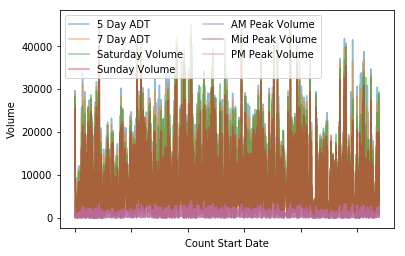

In [32]:
fig, ax = plt.subplots()
for col in ['5 Day ADT', '7 Day ADT', 'Saturday Volume', 'Sunday Volume', 'AM Peak Volume', 'Mid Peak Volume', 'PM Peak Volume']:
# plt.plot(df.index, df[col], alpha = 0.7, label = col)
    df.plot(y = col, ax = ax, alpha = 0.5, label = col)
plt.legend(loc = 2, ncol = 2)
plt.xlabel('Count Start Date')
plt.ylabel('Volume')
